# Quantum Simulation with Qiskit Nature

# Introduction

## Time-dependent Schrödinger Equation
$$
\hat{\mathcal{H}} |\psi(t) \rangle = -i\hbar \frac{\partial}{\partial t} |\psi(t) \rangle
$$

$$
\hbar \equiv 1 \qquad \textrm{drop hats} \qquad \textrm{omit time}
$$

$$
\mathcal{H} |\psi\rangle = i \frac{\partial}{\partial t} |\psi \rangle
$$

$$
\mathcal{H} |\psi\rangle = i \frac{\partial}{\partial t} |\psi \rangle \qquad \Longrightarrow \qquad
|\psi \rangle = e^{-i\mathcal{H} t} |\psi_0 \rangle
$$

## Time-dependent Schrödinger Equation
$$
\mathcal{H} |\psi\rangle = i \frac{\partial}{\partial t} |\psi \rangle \qquad \Longrightarrow \qquad
|\psi \rangle = e^{-i\mathcal{H} t} |\psi_0 \rangle = U |\psi_0 \rangle
$$

We say call this *unitary* time evolution by $U$ from an initial state $|\psi_0\rangle$.

Quantum circuits are also implemented by unitary operations called *quantum gates*.

Question: can we use quantum computers to simulate how quantum states evolve in time? YES

Say we've got a quantum system out there in this cloud or something.

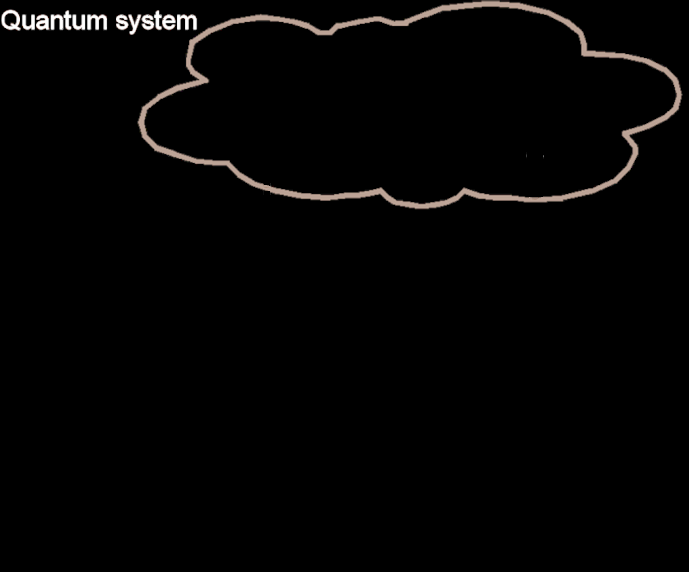

[[I Georgescu, et al, Rev Mod Phys 86, 153 (2014)]](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.153)

The suppose we know it evolves from a state $\phi$ at time 0 to time $t$ under time evolution operator $U$.

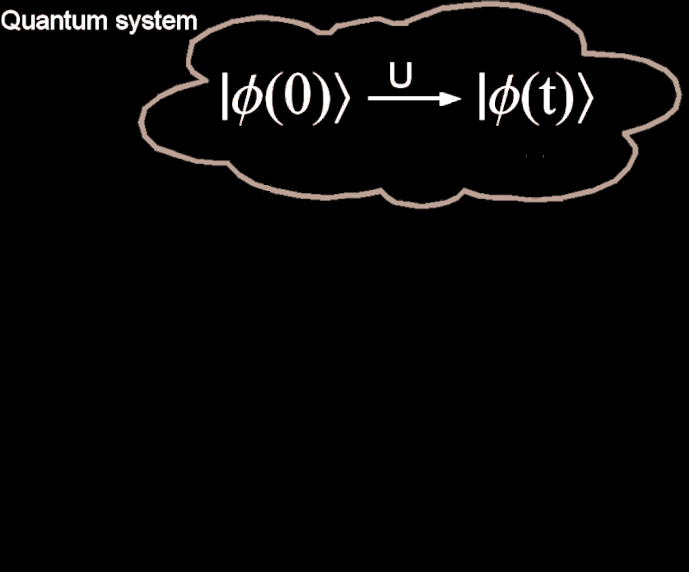

[[I Georgescu, et al, Rev Mod Phys 86, 153 (2014)]](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.153)

Then also suppose we had a quantum simulator we could prepare in the state $\psi$ at time 0 and evolve it by $U'$ to time $t$ and measure it. 

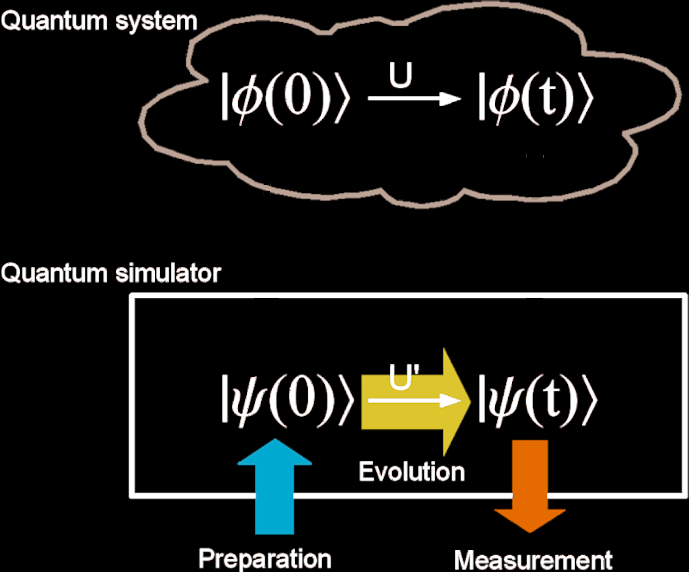

[[I Georgescu, et al, Rev Mod Phys 86, 153 (2014)]](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.153)

Then we could learn about the system $\phi$ by simulating the state $\psi$ with a quantum computer.

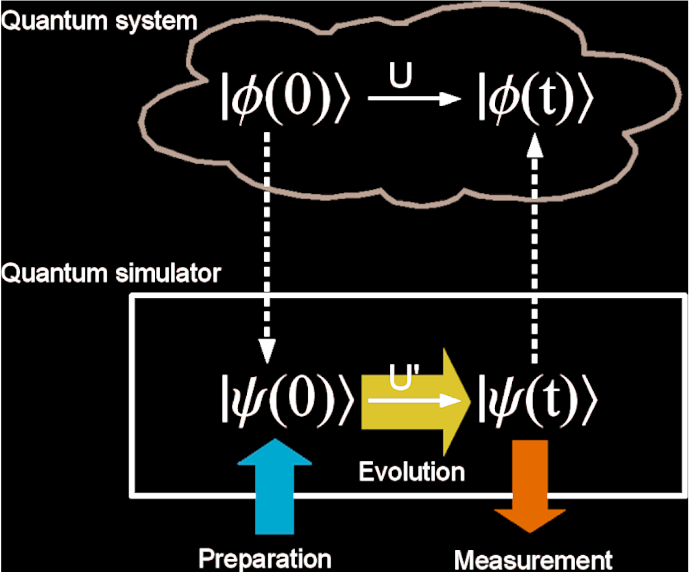

[[I Georgescu, et al, Rev Mod Phys 86, 153 (2014)]](https://journals.aps.org/rmp/abstract/10.1103/RevModPhys.86.153)

Take for example the simulation of electronic systems.

Electrons are types of fermions, which obey commutation relations different from that of qubits. We can write the Hamiltonian of a molecule, say, as a sum of overlap integrals given by the $h$'s and fermionic creation and annihilation operators.

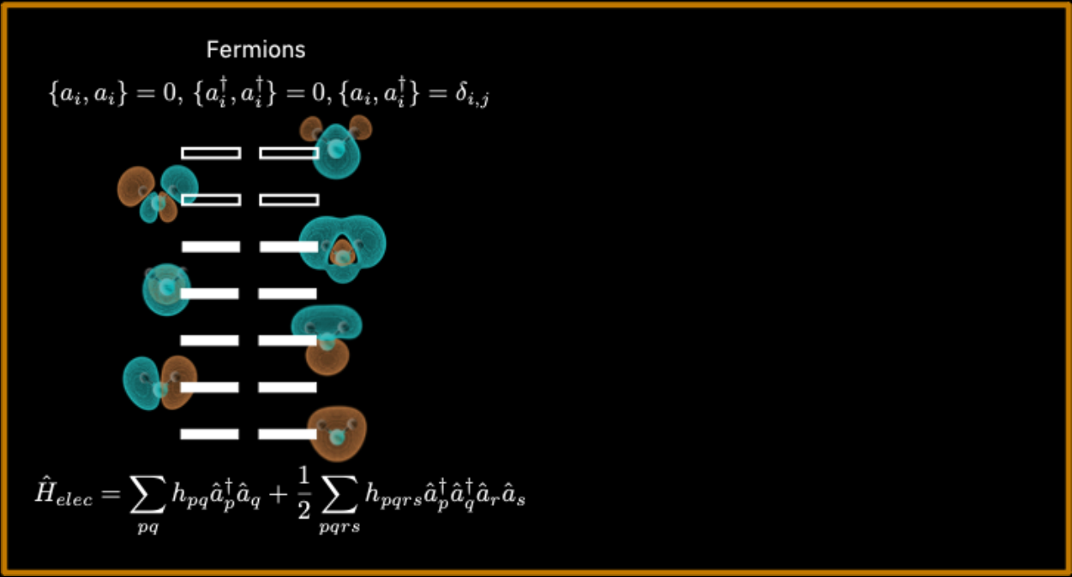

Qubits obey different commutations, the same ones and spins. But yet we can map the fermionic operators to the spin operators in a systematic way, and then we have a qubit Hamiltonian that behaves like the molecular Hamiltoniain.

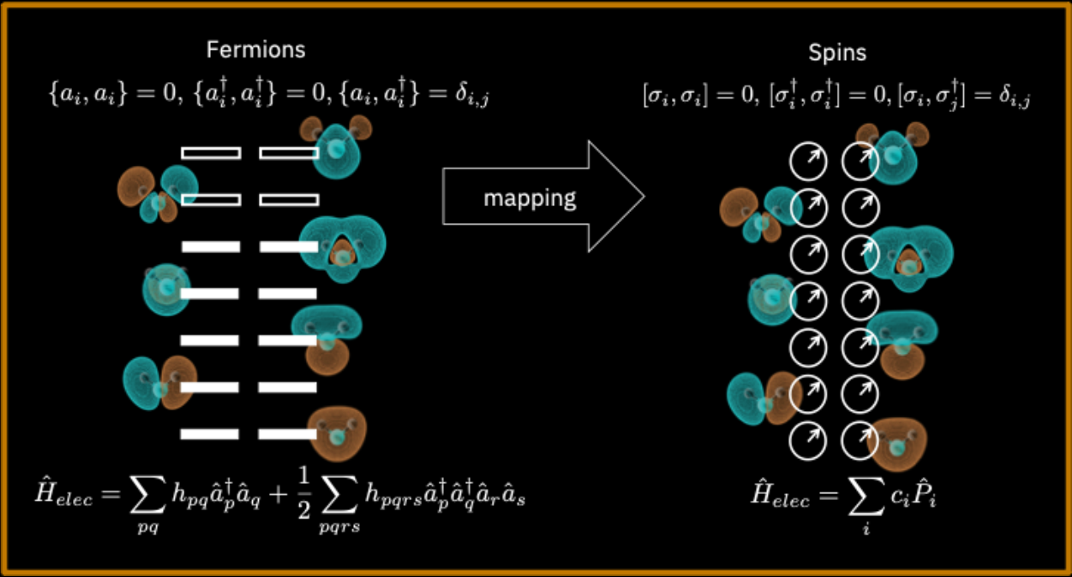

One of these mappings (there are several) allows one to write fermionic operators in terms of Pauli matrices, and thus a way to encode electronic quantum problems on a quantum computer.

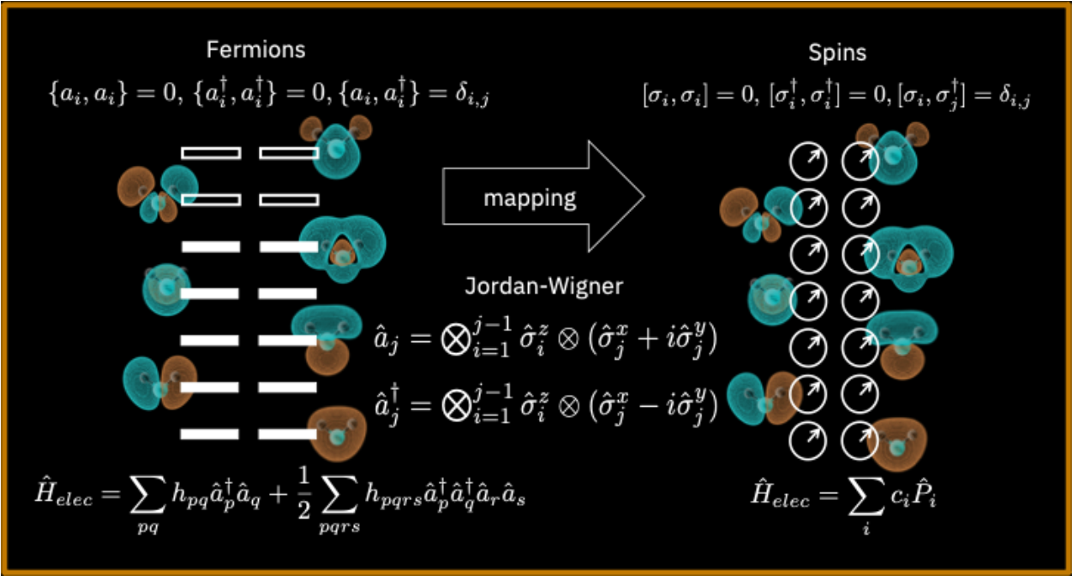

Maps encodings, interactions in Hamiltonians can map across spin sectors so that they are local on hardware.

The cool thing is that we can do this easily with Qiskit Nature!

If you haven't already, install Qiskit Nature. You can do this inside the notebook or inside the conda environment associated with your ipython kernel, as discussed in the install videos.

In [1]:
# install inside notebook
!pip install qiskit-nature

Next, let's load some libraries from Qiskit Nature we'll be using.

In [1]:
from qiskit_nature.operators.second_quantization import FermionicOp
from qiskit_nature.mappers.second_quantization import JordanWignerMapper #or BravyiKitaevMapper or ParityMapper
from qiskit_nature.converters.second_quantization.qubit_converter import QubitConverter

import matplotlib.pyplot as plt
plt.style.use('dark_background')

As an example, we'll simulate an excitation on a 5-site tight binding model. This is a model of a single electron on a chain given by hopping energies $\tau_i$.

## $N$-site Spinless Tight-Binding Model

The Hamiltonian of the chain is
$$
\mathcal{H} = - \sum_{i=0}^{N-2} \tau_i \left( c_i^\dagger c_{i+1} + c_{i+1}^\dagger c_i \right)
$$

And we'll place a defect in the chain

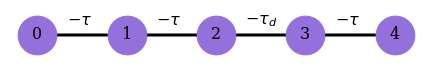

Let's use `FermionicOp` from Qiskit Nature to collect the hopping terms. Each creation operator is given by a 'plus' with a subscript corresponding to the site it acts on and each annihilation operators is similarly specified by a 'minus'. We pick 5 sites to model.

In [2]:
N_sites = 5
hopping_terms = []

for ii in range(N_sites-1):
    hopping_terms.append(sum(FermionicOp(label, register_length=N_sites) 
                             for label in ['+_%i -_%i' % (ii, ii+1), 
                                           '+_%i -_%i' % (ii+1, ii)]))

/var/folders/lz/ccbfpt8928jglgv0n8q2lxw00000gn/T/ipykernel_53820/3523927221.py:5: UserWarning: The default value for `display_format` will be changed from 'dense' to 'sparse' in version 0.3.0. Once that happens, you must specify display_format='dense' directly.
  hopping_terms.append(sum(FermionicOp(label, register_length=N_sites)


In [3]:
hopping_terms

[FermionicOp([('+-III', (1+0j)), ('-+III', (-1+0j))], register_length=5, display_format='dense'),
 FermionicOp([('I+-II', (1+0j)), ('I-+II', (-1+0j))], register_length=5, display_format='dense'),
 FermionicOp([('II+-I', (1+0j)), ('II-+I', (-1+0j))], register_length=5, display_format='dense'),
 FermionicOp([('III+-', (1+0j)), ('III-+', (-1+0j))], register_length=5, display_format='dense')]

First build a qubit converter to convert our fermionic hamiltonian to a Pauli hamiltonian via the Jordan-Wigner transformation, although we could easily pick another.

In [4]:
mapper = JordanWignerMapper() # BravyiKitaevMapper(), etc
converter = QubitConverter(mapper=mapper, two_qubit_reduction=True)

Now suppose we have the same $\tau$ for between all sites, except "defects" which have $\tau_d$.

Introduce `Parameter`s $\tau$ and  $\tau_d$ to put in our Hamiltonian. Choose our defect site at index 2, and build our j-w transformed Hamiltonian.

In [5]:
from qiskit.circuit import Parameter
tau = Parameter('$\\tau$')
tau_def = Parameter('$\\tau_d$')

defect_sites = [2]
ham_jw = 0
for hidx, hopping_term in enumerate(hopping_terms):
    if hidx in defect_sites:
        ham_jw += tau_def*converter.convert(hopping_term)
    else:
        ham_jw += tau*converter.convert(hopping_term)

In [6]:
ham_jw

SummedOp([PauliSumOp(SparsePauliOp(['IIIXX', 'IIIYY'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau$), PauliSumOp(SparsePauliOp(['IIXXI', 'IIYYI'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau$), PauliSumOp(SparsePauliOp(['IXXII', 'IYYII'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau_d$), PauliSumOp(SparsePauliOp(['XXIII', 'YYIII'],
              coeffs=[0.5+0.j, 0.5+0.j]), coeff=1.0*$\tau$)], coeff=1.0, abelian=False)

Now we have our Pauli Hamiltonian after a Jordan-Wigner encoding. Note that the order of operators is switched now such that qubit 0 is the least significant digit (rightmost).

Once we have the Pauli Hamiltonian (that we can implement on our quantum computer), we have many choices of which algorithm to use, depending on what we want to measure. If we're looking for the ground state of a molecular configuration, we might choose the variational quantum eigensolver (as in Owen's video). If we're looking for the spectrum of our Hamiltonian or dynamical correlation functions, we might try controlled time evolution by auxiliary qubits.

Or we might even try spectroscopic techniques to interact the qubits undergoing evolution with probe qubits. 

In the following example, we will measure the qubits directly to see how an excitation propagates along a chain of electron sites.

In all these cases, we must first prepare the initial state of the qubits representing our simulated system.

We'll do the following within Qiskit Opflow, a module within Qiskit Terra, to manipulate qubit operators and build quantum circuits from them.

Prepare initial state $|\psi_0\rangle = |00001\rangle$.

In [7]:
from qiskit.opflow import Zero, One
psi_0 = (Zero^(N_sites-1))^One

Build time-evolution operator $U = e^{-i\mathcal{H}t}$ by simply exponentiating it.

(This is needed in most simulation algorithms, but not necessarily VQE).

In [8]:
tt = Parameter('$t$')
U_ham = (tt*ham_jw).exp_i()
print(U_ham)

e^(-i*1.0*$t$ * SummedOp([
  1.0*$\tau$ * (
    0.5 * IIIXX
    + 0.5 * IIIYY
  ),
  1.0*$\tau$ * (
    0.5 * IIXXI
    + 0.5 * IIYYI
  ),
  1.0*$\tau_d$ * (
    0.5 * IXXII
    + 0.5 * IYYII
  ),
  1.0*$\tau$ * (
    0.5 * XXIII
    + 0.5 * YYIII
  )
]))


In Qiskit Opflow, the carrot symbol `^` corresponds to a tensor product.

Since we want to measure the wavefunction density, prepare measurement operators $n_i$ in the Pauli basis that give us the occupation observable.

We perform a Jordan-Wigner transform on the number operators to get their corresponding Pauli operators.

In [9]:
Nops = []

for ii in range(N_sites):
    Nops.append(converter.convert(FermionicOp('N_%i' % ii, register_length=N_sites)))

Finally, build the expectation values $\langle \psi_0 | U_{\rm ham}^\dagger n_i U_{\rm ham} |\psi_0 \rangle$,

In Opflow, the at `@` symbol corresponds to operator composition.

In [10]:
Nexps_exact = []

for Nop in Nops:
    Nexps_exact.append((U_ham @ psi_0).adjoint() @ Nop @ (U_ham @ psi_0))

And choose the parameters for our simulation.

In [11]:
param_bind = {
    tau: 1,
    tau_def: 0.5,
}

First, we'll use Opflow to calculate the results of our simulation exaclty. Later we'll show how to approximate this with a quantum computer.

Import `PauliExpectation` and define the time range from 0 to 10. For each of our expectation values, calculate the measurement operators by converting them and then evaluating them at each desired time step.

In [12]:
from qiskit.opflow import PauliExpectation
import numpy as np
time_range = np.linspace(0, 10, 51)

Nexps_values = []
for Nexp in Nexps_exact: 
    diag_meas_op = PauliExpectation().convert(Nexp)
    Nexp_values = []
    for t_set in time_range:
        param_bind[tt] = t_set
        Nexp_values.append(diag_meas_op.bind_parameters(param_bind).eval())
        
    Nexps_values.append(Nexp_values)

Next let's plot a colormap of our results.

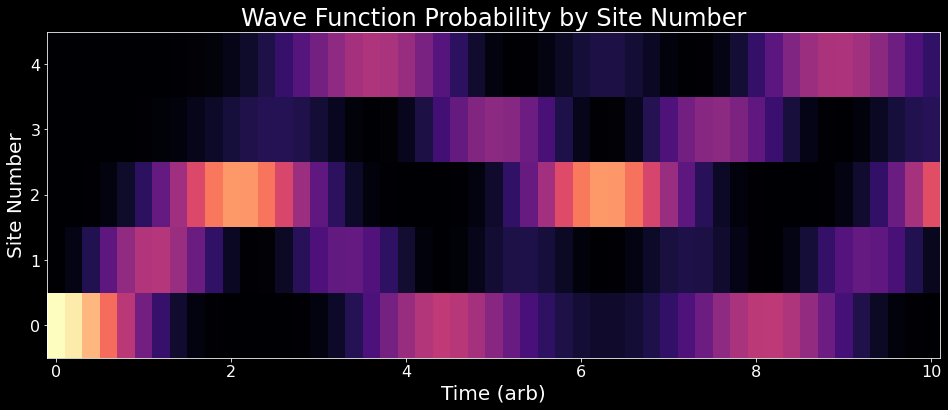

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pcm = ax.pcolormesh(time_range, range(N_sites), np.real(np.asarray(Nexps_values)), 
                    shading='auto', vmin=0., vmax=1., cmap='magma')
plt.title('Wave Function Probability by Site Number', fontsize=24)
plt.xlabel('Time (arb)', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Site Number', fontsize=20)
_ = plt.yticks(fontsize=16)

Here we can see our excitation on site 0 at time 0 propagates along the chain, and being both transmitted and reflected from the defect, followed by mostly construtive interference back at site 2 around time 6. 

The lightness of the color gives the wavefunction probability, so we can indeed see that we are observing a quantum mechanical effect!

## Trotterization

Typically we cannot implement time evolution of the whole Hamiltonian on a quantum computer. Additionally, terms of the Hamiltonian may not commute with each other. We use a technique called Trotterization to break it up into smaller pieces, each of which "does not commute" that badly with each other by taking small time steps. In this way, Trotterization is an approximate decomposition that allows us to do simulation on our quantum computer, and we can always increase the order and/or the number of repetitions for desired accuracy. Of course, this could be balanced by the errors of running longer circuits.

We can further decompose this circuit to look deeper inside.

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


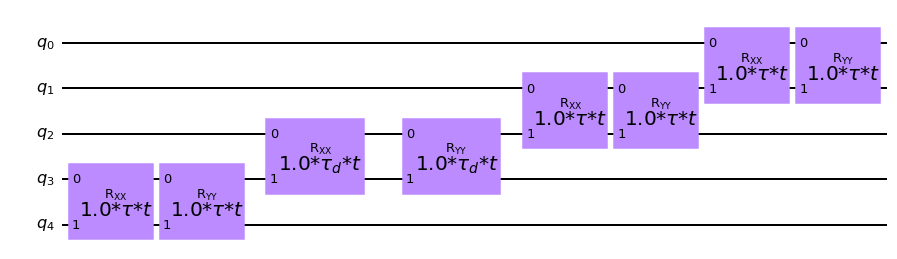

In [18]:
from qiskit.opflow import PauliTrotterEvolution, Suzuki
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=1, reps=1)).convert(U_ham)
trot_op.to_circuit().decompose().decompose().draw(output='mpl', style={'subfontsize': 20})

Or just transpile it into qubit operations that we're familiar with.

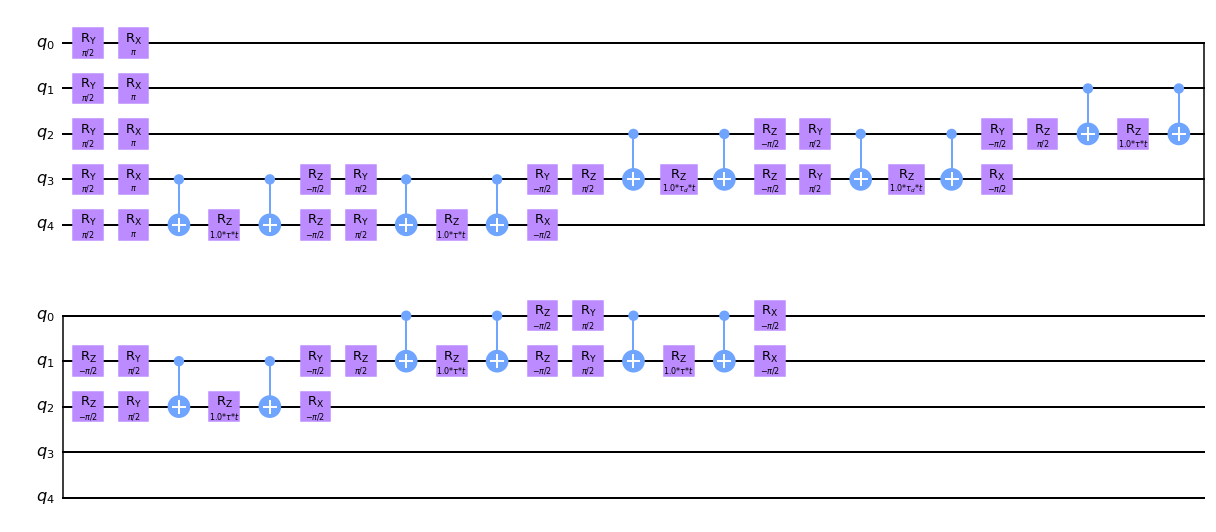

In [19]:
from qiskit import transpile
transpile(trot_op.to_circuit(), basis_gates=['rx','ry','rz','cx']).draw(output='mpl')

We'll do the simulation error-free with the `ibm_qasm_simulator`.

In [19]:
from qiskit import IBMQ, QuantumCircuit
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend_sim = provider.get_backend('ibmq_qasm_simulator')

In [20]:
num_trot_steps = 5
trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, reps=num_trot_steps)).convert(U_ham)

trot_circ = QuantumCircuit(N_sites)
trot_circ.x(0) # excite qubit 0
trot_circ.compose(trot_op.to_circuit(), range(N_sites), inplace=True)
trot_circ.measure_all()

Nexp_circs = []
for t_set in time_range:
    param_bind[tt] = t_set
    trot_circ_t = transpile(trot_circ.bind_parameters(param_bind), 
                            basis_gates=['rx', 'ry', 'rz', 'cx'])
    Nexp_circs.append(trot_circ_t)

Evolved Hamiltonian is not composed of only Paulis, converting to Pauli representation, which can be expensive.


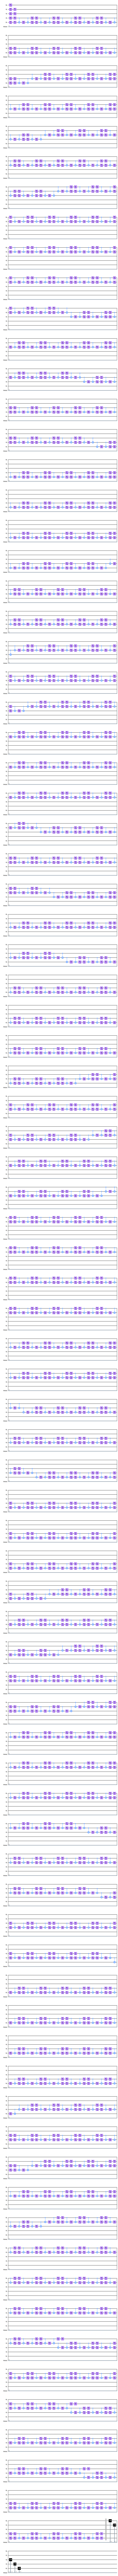

In [21]:
Nexp_circs[-1].draw('mpl')

As we can see, this is a rather long circuit, which is why we're running this on a noiseless quantum simulator, but running this cell.

In [22]:
job = backend_sim.run(Nexp_circs)

We'll then extract the probability for each site to be occupied by going through our results and summing the counts where the qubits are excited.

In [23]:
total_counts = []
for result in job.result().results:
    counts = np.zeros((N_sites))
    for key in result.data.counts:
        key_bin = format(int(key.split('x')[1], 16), '0%ib' % N_sites)
        count = result.data.counts[key]
        for idx in range(N_sites):
            if key_bin[N_sites - idx - 1] == '1':
                counts[idx] += count
    total_counts.append(list(counts/sum(counts))) # normalize

And again, we'll plot the results and get qualitative agreement with what we produced before. One of the challenges of doing quantum simulation on noisy quantum computers is the tradeoff between accuracy from the number of Trotter steps, and the noise accumulated from running a longer circuit depth. 

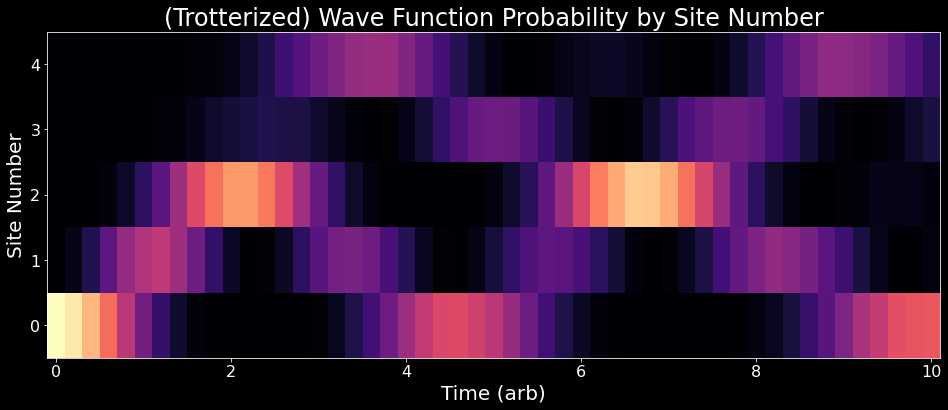

In [24]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pcm = ax.pcolormesh(time_range, range(N_sites), np.transpose(np.asarray(total_counts)), 
                    shading='auto', vmin=0., vmax=1., cmap='magma')
plt.title('(Trotterized) Wave Function Probability by Site Number', fontsize=24)
plt.xlabel('Time (arb)', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Site Number', fontsize=20)
_ = plt.yticks(fontsize=16)

In this video, we've learned how to express a fermionic Hamiltonian and transform it into a Pauli (or qubit) Hamiltonian in Qiskit Nature. We then excited a qubit to simulate how an electron wavefunction would propagate along a 5-site chain on a quantum computer using Qiskit Opflow.

Let us know in the comments what else you'd like to see explored with Qiskit modules.

I've been your host Nick Brønn, thanks for watching!

In [ ]:
import qiskit.tools.jupyter
%qiskit_version_table

This should be exactly equivalent to the circuit way of doing things, but using `.eval()` function instead of `ibmq_qasm_simulator` explicitly.

In [ ]:
Nexps_trot_values = []
for Nexp in Nexps_exact: 
    sim_trot_op = PauliTrotterEvolution(trotter_mode=Suzuki(order=2, 
                                reps=num_trot_steps)).convert(Nexp)
    Nexp_trot_values = []
    for t_set in time_range:
        param_bind[tt] = t_set
        trot_ham_exps = sim_trot_op.bind_parameters(param_bind)
        Nexp_trot_values.append(trot_ham_exps.eval())
        
    Nexps_trot_values.append(Nexp_trot_values)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
pcm = ax.pcolormesh(time_range, range(N_sites), np.real(np.asarray(Nexps_trot_values)), 
                    shading='auto', vmin=0., vmax=1., cmap='magma')
plt.title('(Trotterized) Wave Function Probability by Site Number', fontsize=24)
plt.xlabel('Time (arb)', fontsize=20)
plt.xticks(fontsize=16)
plt.ylabel('Site Number', fontsize=20)
_ = plt.yticks(fontsize=16)